# Changes-of-mind 2019

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import data_reader
import matplotlib.patches as mpatches
import os
import matplotlib.lines as mlines
###################################
%matplotlib inline
mpl.matplotlib_fname();

## Read model simulation outputs

In [5]:
# csv files variables- for better readability:
csv_path = '../output/csv/'
model_psychometric_function_non_com= pd.read_csv(os.path.join(csv_path, 'psychometric_function.txt'), sep=',')
model_psychometric_function_com= pd.read_csv(os.path.join(csv_path, 'psychometric_function_com.txt'), sep=',')
model_response_times_non_com= pd.read_csv(os.path.join(csv_path, 'response_times_non_com.txt'), sep=',')
model_response_times_com= pd.read_csv(os.path.join(csv_path, 'response_times_com.txt'), sep=',')
model_p_com = pd.read_csv(os.path.join(csv_path, 'p_com.txt'), sep=',')
model_p_com_tertiles= pd.read_csv(os.path.join(csv_path, 'model_tertiles.txt'), sep=',')
model_noncom_x_trajectory=  pd.read_csv(os.path.join(csv_path, 'x_traj_non_com.txt'), sep=',')
model_com_x_trajectory= pd.read_csv(os.path.join(csv_path, 'x_traj_com.txt'), sep=',')
model_noncom_mean_trajectory= pd.read_csv(os.path.join(csv_path, 'x_traj_non_com_mean.txt'), sep=',')
model_com_mean_trajectroy= pd.read_csv(os.path.join(csv_path, 'x_traj_com_mean.txt'), sep=',')
model_tertiles = pd.read_csv(os.path.join(csv_path, 'model_tertiles.txt'), sep=',')

# Exclude response times from 51.2 com trials- number of trials too low.
model_response_times_non_com.init_z_error.loc[5] = np.nan
model_response_times_com.init_z_correct.loc[5] = np.nan
model_response_times_com.init_z_error.loc[5] = np.nan

### Set this to a custom path if you want to save figures elsewhere

In [6]:
global save_path
save_path= '../output/figures'

## Read choices and dynamics data for experiment

In [7]:
dr = data_reader.DataReader()
index = ['subj_id', 'session_no', 'block_no', 'trial_no']

data_path = 'C:/Users/Arkady/Google Drive/data/CoM_fixed_duration/processed'
# data_path = '../../data/experimental_data/exp1/'
choices, dynamics = dr.get_data(path=data_path, stim_viewing=False, rename_vars=True)
choices = choices.reset_index()

## Function to plot psychometric function. 

In [13]:
def get_ci(c, n_threshold=0):
    psf = np.array([len(c[(c.is_correct) & (c.coherence==coherence) & (c.type==t)]) / 
                   len(c[(c.coherence==coherence) & (c.type==t)]) 
               if len(c[(c.coherence==coherence) & (c.type==t)]) > n_threshold else np.NaN  
           for coherence in np.sort(c.coherence.unique()) 
           for t in np.sort(c.type.unique())])
    n = [len(c[(c.coherence==coherence) & (c.type==t)]) 
                      for coherence in np.sort(c.coherence.unique()) 
                      for t in np.sort(c.type.unique())]

    ci = pd.DataFrame(psf, columns=['p_correct'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c.type.unique())], 
                                                         names=['coherence', 'type']))
    ci['ci_l'] = ci['p_correct'] - np.sqrt(psf*(1-psf)/n)
    ci['ci_r'] = ci['p_correct'] + np.sqrt(psf*(1-psf)/n)
    
    return ci.reset_index()

In [14]:
def plot_psychometric_function(model_non_com, model_com, c, n_threshold = 10):
    global save_path
    local_save_path = save_path 
        
    c = c[c.coherence!=0]
    psf = [len(c[(c.is_correct) & (c.coherence==coherence) & (c.type==t)]) / 
                   len(c[(c.coherence==coherence) & (c.type==t)]) 
               if len(c[(c.coherence==coherence) & (c.type==t)]) > n_threshold else np.NaN  
           for coherence in np.sort(c.coherence.unique()) 
           for t in np.sort(c.type.unique())]
    
    p_correct = pd.DataFrame(psf, columns=['p_correct'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c.type.unique())], 
                                                         names=['coherence', 'type']))
    
    fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
    
    sns.pointplot(data=p_correct.reset_index(), x='coherence', y='p_correct', hue='type',
                    styles=['o', 'v'], scale = 0.75, join=True, palette=['grey', 'black'], linestyles=['-', '-'], ax = ax[0])
    ci = get_ci(c)

    ax[0].vlines(x=range(0,5), ymin=ci[ci.type=='non-CoM'].ci_l, ymax=ci[ci.type=='non-CoM'].ci_r, 
                 color='black', zorder=10)
    
    ax[0].vlines(x=range(0,5), ymin=ci[ci.type=='CoM'].ci_l, ymax=ci[ci.type=='CoM'].ci_r, 
                 color='grey', zorder=10)
    
    ax[0].get_yaxis().set_major_locator(mpl.ticker.FixedLocator(np.linspace(0.4, 1.0, 7)))
    plt.sca(ax[0])
    sns.despine(ax=ax[0], trim=True, offset=10)
    
    ax[0].axes.get_legend().set_title('')
    
    plt.title('Experiment')
    plt.xlabel('Coherence')
    plt.ylabel('p(Correct)')
    
    plt.sca(ax[1])
    plt.plot([0,1,2,3,4],model_non_com.pcorrect_y_real.iloc[1:], label = 'Model non-com', color='black',marker='o',ls='-')
    plt.plot([0,1,2,3],model_com.pcorrect_y_real.iloc[1:5], label = 'Model com', color='grey',marker='o',ls='-')
    ax[1].set_xticklabels(['0.032','0.064','0.128','0.256','0.512'])
    ax[1].get_yaxis().set_major_locator(mpl.ticker.FixedLocator(np.linspace(0.4, 1.0, 7)))
    sns.despine(ax=ax[1], trim=True, offset=10)
    leg_handles = ax[0].get_legend_handles_labels()[0]
    
    plt.xlabel('Coherence')
    plt.title('Model')
    
    plt.savefig(os.path.join(local_save_path, 'psychometric_func.png'), bbox_inches='tight')

### Qualitative aspects (accuracy of CoM is worse) are replicated

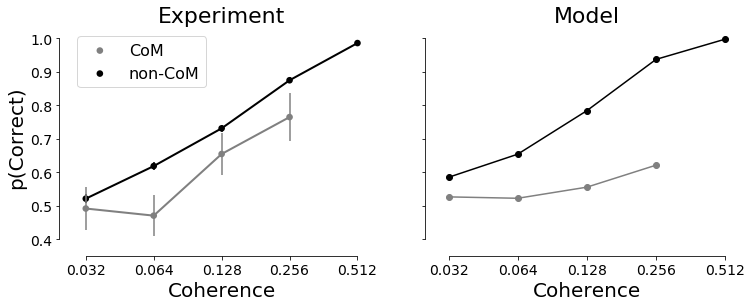

In [15]:
plot_psychometric_function(model_psychometric_function_non_com, model_psychometric_function_com, choices)

###  Calculates confidence intervals for probabilities of changes-of-mind

In [8]:
def get_ci_p_com(c, correct_col='is_correct', n_threshold=10):
    p_com = np.array([len(c[(c.is_com) & (c.coherence==coherence) & (c[correct_col]==is_correct)]) / 
                   len(c[(c.coherence==coherence)]) 
               if (len(c[(c.is_com) & (c.coherence==coherence) & (c[correct_col]==is_correct)])>n_threshold) else np.NaN  
           for coherence in np.sort(c.coherence.unique()) 
           for is_correct in np.sort(c[correct_col].unique())])
    n = [len(c[(c.coherence==coherence) & (c[correct_col]==is_correct)]) 
                      for coherence in np.sort(c.coherence.unique()) 
                      for is_correct in np.sort(c[correct_col].unique())]

    ci = pd.DataFrame(p_com, columns=['p_com'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c[correct_col].unique())], 
                                                         names=['coherence', correct_col]))
    ci['ci_l'] = ci['p_com'] - np.sqrt(p_com*(1-p_com)/n)
    ci['ci_r'] = ci['p_com'] + np.sqrt(p_com*(1-p_com)/n)
    
    return ci.reset_index()

def get_ci_p_com_total(c, n_threshold=10):
    p_com_total = [(len(c[(c.is_com) & (c.coherence==coherence)]) / len(c[(c.coherence==coherence)]), coherence)
               if (len(c[(c.is_com) & (c.coherence==coherence)]) > n_threshold) else (np.NaN, coherence)
           for coherence in np.sort(c.coherence.unique())]
    
    n = [len(c[(c.coherence==coherence)]) for coherence in np.sort(c.coherence.unique())]
    
    ci = pd.DataFrame(p_com_total, columns=['p_com', 'coherence'])  
    
    p_com = ci.p_com
    ci['ci_l'] = ci['p_com'] - np.sqrt(p_com*(1-p_com)/n)
    ci['ci_r'] = ci['p_com'] + np.sqrt(p_com*(1-p_com)/n)
    
    return ci.reset_index()

## Plot experiment and model P(CoM) side by side

In [9]:
def plot_p_com(model_p_com, c):
    global save_path
    local_save_path = save_path
    
    n_threshold = 0
    correct_col='is_correct'
    
    #Experimental data: 
    plt.figure()
    local_save_path = '../output/figures'
    p_com_total = [(len(c[(c.is_com) & (c.coherence==coherence)]) / len(c[(c.coherence==coherence)]), coherence)
                   if (len(c[(c.is_com) & (c.coherence==coherence)]) > n_threshold) else (np.NaN, coherence)
                   for coherence in np.sort(c.coherence.unique())]
    
    p_com_total = pd.DataFrame(p_com_total, columns=['p_com', 'coherence'])
#     p_com_total.loc[5].p_com=0
    fig, ax = plt.subplots(ncols=2, figsize=(12,4), sharey=True)
    
    sns.pointplot(data=p_com_total, x='coherence', y='p_com', scale=0.75, color='grey', join=True, ax=ax[0])
    
    p_com = [len(c[(c.is_com) & (c.coherence==coherence) & (c[correct_col]==is_correct)]) / 
                   len(c[(c.coherence==coherence)]) 
             if (len(c[(c.is_com) & (c.coherence==coherence) & (c[correct_col]==is_correct)]) > n_threshold) else 0  
             for coherence in np.sort(c.coherence.unique()) 
             for is_correct in np.sort(c[correct_col].unique())]
    
    p_com = pd.DataFrame(p_com, columns=['p_com'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c.is_correct.unique())], 
                                                         names=['coherence', correct_col]))
    # no correct/error labels for zero coherence
    p_com.loc[0] = np.NaN

    sns.pointplot(data=p_com.reset_index(), x='coherence', y='p_com', hue=correct_col,
                       palette=['k', 'k'], linestyles=['--', '-'], scale=0.75, ax=ax[0], join = True)
    
    ci_total = get_ci_p_com_total(c, n_threshold=n_threshold)
    ax[0].vlines(x=range(0,6), ymin=ci_total.ci_l, ymax=ci_total.ci_r, color='grey', zorder=10)
    
    ci = get_ci_p_com(c, correct_col, n_threshold=n_threshold)
    ax[0].vlines(x=[val for pair in zip(range(1,6), range(1,6)) for val in pair], 
              ymin=ci[ci.coherence>0].ci_l, ymax=ci[ci.coherence>0].ci_r, color='black', zorder=10)

    ax[0].set_ylim(-0.005, 0.06)
    ax[0].legend(handles=ax[0].lines[::len(choices.coherence.unique())+1], 
                 labels=['Total','Error','Correct'], frameon=False)
    
    ax[0].set_title('Experiment')
       
    ax[0].set_xlabel('Coherence')
    ax[0].set_ylabel('p(CoM)')
    sns.despine(ax=ax[0], trim=True, offset=10)
    
    model_p_com['p_com_correct'][0] = np.NaN
    model_p_com['pcom_incorrect'][0] = np.NaN
    
#     plt.sca(ax[1])
    ax[1].plot(range(6), model_p_com.p_com_all, marker = 'o', color='grey', label='Total',ls='-')
    ax[1].plot(range(6), model_p_com.p_com_correct, marker = 'o', color='black', label='Correct',ls='-')
    ax[1].plot(range(6), model_p_com.pcom_incorrect, marker = 'o',color='black', label='Error',ls='--')
    
    ax[1].set_title('Model')        
    ax[1].set_xlabel('Coherence')

    ax[1].set_xticklabels(('0.0', '0.032', '0.064', '0.128', '0.256', '0.512'))
    ax[1].set_ylim(-0.005, 0.06)
    sns.despine(ax=ax[1], trim=True, offset=10)
    
    plt.savefig(os.path.join(local_save_path, 'p_com.png') , bbox_inches='tight')

### Decaying overall probability of changes-of-mind. Correct/error split is close in all cases except 25.6.


<Figure size 432x288 with 0 Axes>

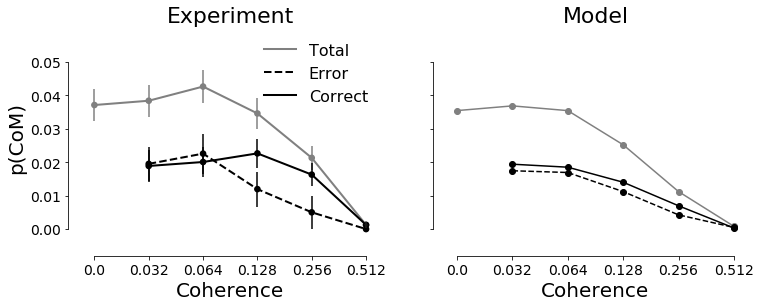

In [10]:
plot_p_com(model_p_com, choices)

### Response times plots

In [11]:
def plot_var_exp_model(model, choices, var, is_com, estimator=np.mean):
    # In this plot, we exclude two changes-of-mind at 0.512 coherence
    choices = choices[~(choices.coherence == 0.512) | (choices.is_com == False)]
    
    global save_path
    local_save_path = save_path
    file_string = 'non_com'
    if(is_com):
        file_string = 'com'
        
    plt.figure()
    fig, ax = plt.subplots(ncols=2, figsize=(12,4))
    
    sns.pointplot(data=choices[(choices.coherence > 0) & (~choices.is_correct) & 
                               (choices.coherence != 0.512) & (choices.is_com == is_com)] ,
                       x='coherence', y=var, linestyles=['-'], color='red',
                       markers=['o'], scale=1.0, errwidth=0.5, estimator=estimator,join=True,ax=ax[0])

    sns.pointplot(data=choices[(choices.coherence > 0) & (choices.is_correct) & (choices.is_com == is_com)],
                       x='coherence', y=var, linestyles=['-'], color='green',
                       scale=1.0, errwidth=0.5, estimator=estimator, ax=ax[0], join=True)
    
    ax[0].set_xlabel('Coherence')
    ax[0].set_ylabel(var)
        
    correct_line = mlines.Line2D([], [], color='green', marker='o', ls='',label='correct')
    error_line = mlines.Line2D([], [], color='red', marker='o', ls='',label='error')
    correct_line_model = mlines.Line2D([], [], color='green', marker='s', ls='', mfc='none', label='correct')
    error_line_model = mlines.Line2D([], [], color='red', marker='s', ls='', mfc='none',label='error')
    
    plt.sca(ax[0])
    plt.legend(handles=[correct_line, error_line], frameon=True)
    ax[0].set(ylim=(-2.0, 2.0))
    plt.title('Experiment')

    ax[0].set_ylabel('Response time (z)')
    plt.tight_layout()

    plt.sca(ax[1])

    plt.errorbar(x=[0,1,2,3,4], y=model.init_z_correct[1::], yerr=model.init_z_correct_sem[1::],
                 ls='--',fmt='-s',color='green', mfc='none', label='Correct')
    plt.errorbar(x=[0,1,2,3,4], y=model.init_z_error[1::], yerr=model.init_z_error_sem[1::],
                 ls='--',fmt='-s', color='red', mfc='none', label='Error')

    plt.legend(handles=[correct_line_model, error_line_model], frameon=True)
    ax[1].set(ylim=(-2.0, 2.0))
    plt.title('Model')
    plt.xticks(np.arange(5), ('0.032', '0.064', '0.128', '0.256', '0.512'))
    
    if(is_com):
        plt.xticks(np.arange(5), ('0.032', '0.064', '0.128', '0.256'))
    ax[1].set_ylabel('Response time (z)')
    plt.tight_layout()
    
    plt.savefig(os.path.join(local_save_path, var + '_' + file_string + '.png'), bbox_inches='tight')

## Model fit for response times

#### non com RT

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

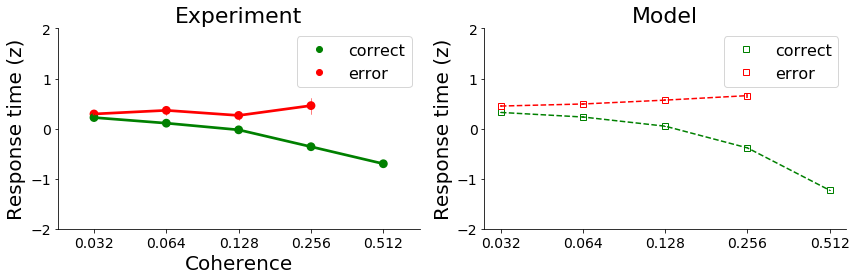

In [12]:
plot_var_exp_model(model_response_times_non_com, choices, 'RT_z', is_com = False)

#### com RT

<Figure size 432x288 with 0 Axes>

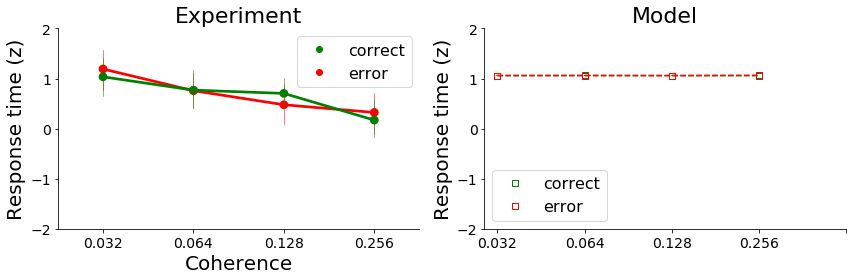

In [13]:
plot_var_exp_model(model_response_times_com,choices, 'RT_z', is_com = True)

In [14]:
def plot_all_rts(model_non_com, model_com, choices):
    # Exclude 51.2 changes-of-mind
    choices = choices.drop(choices[(choices.coherence == 0.512) & (choices.is_com == True)].index)
    var = 'RT_z'
    
    global save_path
    local_save_path = save_path

    plt.figure()
    fig, ax = plt.subplots(ncols=2, figsize=(10,4), sharex=True, sharey=True)
    
    # CoMs will be grey and non-CoMs will be black
    # correct will be solid circles, and error will be dashed crosses   
    sns.pointplot(data=choices[(choices.coherence > 0) & (~choices.is_correct) & (choices.is_com == True)],
                       x='coherence', y=var, linestyles=['--'], color='grey', markers=['x'],
                       scale=1.0, errwidth=0.5, ax=ax[0], join=True)
    
    sns.pointplot(data=choices[(choices.coherence > 0) & (choices.is_correct) & (choices.is_com == True)],
                       x='coherence', y=var, linestyles=['-'], color='grey', markers=['o'],
                       scale=1.0, errwidth=0.5, ax=ax[0], join=True)
    
    sns.pointplot(data=choices[(choices.coherence > 0) & (choices.coherence < 0.512) & 
                               (~choices.is_correct) & (choices.is_com == False)],
                       x='coherence', y=var, linestyles=['--'], color='black', markers=['x'], 
                       scale=1.0, errwidth=0.5, join=True, ax=ax[0])

    sns.pointplot(data=choices[(choices.coherence > 0) & (choices.is_correct) & (choices.is_com == False)],
                       x='coherence', y=var, linestyles=['-'], color='black', markers=['o'],
                       scale=1.0, errwidth=0.5, ax=ax[0], join=True)
    
    ax[0].legend(handles=ax[0].lines[::5], 
                 labels=['Error CoM', 'Correct CoM', 'Error non-CoM', 'Correct non-CoM'], 
                 fontsize=12, frameon=True)
    ax[0].set_xlabel('Coherence')
    ax[0].set_xticks(range(5))
    ax[0].set_xticklabels(('0.032', '0.064', '0.128', '0.256', '0.512'))
    ax[0].set(ylim=(-2.0, 2.0))
    ax[0].set_title('Experiment')
    ax[0].set_ylabel('Response time (z)')
    sns.despine(ax=ax[0], trim=True, offset=10)
    plt.tight_layout()

    ax[1].errorbar(x=range(5), y=model_com.init_z_correct[1::], yerr=model_non_com.init_z_correct_sem[1::],
                 ls='-', fmt='-s',color='grey', label='Correct', marker='o', lw=3, ms=8)
    
    ax[1].errorbar(x=range(5), y=model_com.init_z_error[1::], yerr=model_non_com.init_z_error_sem[1::],
                 ls='--', fmt='-s', color='grey', label='Error', marker='x', lw=3, ms=8)
    
    ax[1].errorbar(x=range(5), y=model_non_com.init_z_correct[1::], yerr=model_non_com.init_z_correct_sem[1::],
                 ls='-', fmt='-s',color='black', label='Correct', marker='o', lw=3, ms=8)
    
    ax[1].errorbar(x=range(5), y=model_non_com.init_z_error[1::], yerr=model_non_com.init_z_error_sem[1::],
                 ls='--', fmt='-s', color='black', label='Error', marker='x', lw=3, ms=8)
        
    ax[1].set_xlabel('Coherence')
    ax[1].set_ylim((-2.0, 2.0))
    ax[1].set_title('Model')
    ax[1].set_xticks(range(5))
    ax[1].set_xticklabels(('0.032', '0.064', '0.128', '0.256', '0.512'))
    sns.despine(ax=ax[1], trim=True, offset=10)
    plt.tight_layout()
    
    plt.savefig(os.path.join(local_save_path, var + '.png'), bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

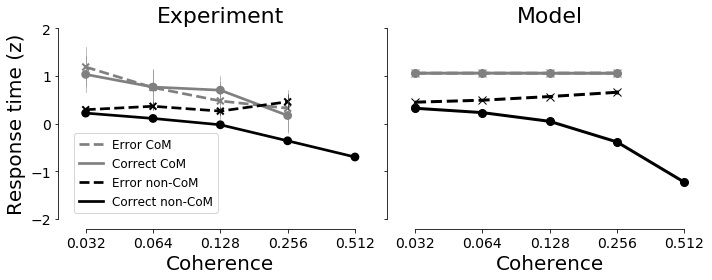

In [15]:
plot_all_rts(model_response_times_non_com,model_response_times_com, choices)

# Tertiles plot function

In [21]:
def get_p_com_per_var(c, var):
    return np.array([(len(c[(c.is_com) & (c.coherence==coherence) & (c[var]==var_level)]) / 
                   len(c[(c.coherence==coherence)])) 
               if len(c[(c.coherence==coherence) & (c[var]==var_level)]) else np.NaN  
           for coherence in np.sort(c.coherence.unique())
           for var_level in np.sort(c[var].unique())])
    
def get_ci_vs_var(choices, var, n_threshold=0):
    p_com = get_p_com_per_var(choices, var)    

    n = choices.groupby(by=['coherence', var]).apply(len)
    ci = pd.DataFrame(p_com, columns=['p_com'], 
                        index=pd.MultiIndex.from_product([np.sort(choices.coherence.unique()), 
                                                          np.sort(choices[var].unique())], 
                                                         names=['coherence', var]))
    ci['ci_l'] = ci['p_com'] - np.sqrt(p_com*(1-p_com)/n)
    ci['ci_r'] = ci['p_com'] + np.sqrt(p_com*(1-p_com)/n)

    return ci.reset_index()
    
def plot_p_com_vs_var_ci(data, var, title, palette='viridis_r', n_threshold=0, ax=None):
    global save_path
    local_save_path = save_path
        
    ci = get_ci_vs_var(data, var, n_threshold=n_threshold)

    ax = sns.pointplot(data=ci, x='coherence', y='p_com', hue=var, palette=palette, ax=ax)
    
    if title=='Experiment':
        ax.vlines(x=[val for pair in zip(range(0,6), range(0,6), range(0,6)) for val in pair], 
              ymin=ci.ci_l, ymax=ci.ci_r, color='gray', zorder=0)
        ax.set_ylabel('p(CoM)')
    else:
        ax.legend().remove()
        ax.set_ylabel('')

    ax.set_xlabel('Coherence')
    ax.set_ylim(-0.005, 0.05)    
    ax.set_title(title)
    
    sns.despine(ax=ax, trim=True, offset=5)    

    return ax

### The following confirms that in the model, CoM are more likely when initiation time is slowest and in lower coherence levels.

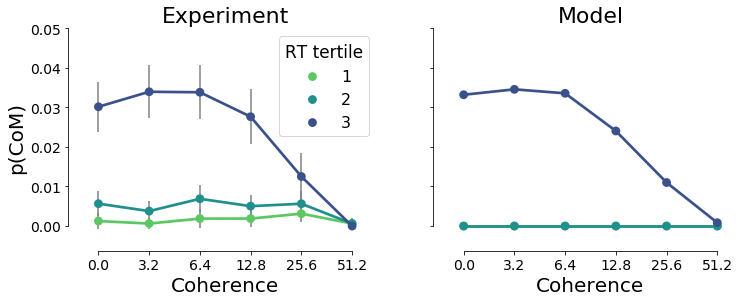

In [22]:
model_tertiles['hand_IT_tertile'] = pd.qcut(model_tertiles['hand_IT'], 3, labels=[1, 2,3])
model_tertiles['is_com'] = model_tertiles['is_com'].astype('bool')

fig, axes = plt.subplots(ncols=2, figsize=(12,4), sharex=True, sharey=True)
plot_p_com_vs_var_ci(choices, 'RT tertile', 'Experiment', n_threshold=10, ax=axes[0])
plot_p_com_vs_var_ci(model_tertiles, 'hand_IT_tertile', 'Model', n_threshold=10, ax=axes[1])
plt.savefig(os.path.join(save_path, 'RT_tertiles.png'), bbox_inches='tight')

# Trajectories

In [59]:
def ms_to_s(traj):
    traj.timestamp= np.linspace(0,4000,4000)
    traj.timestamp = (traj.timestamp - traj.timestamp.min())/1000.0
    return traj

def resample_trajectory(traj, n_steps):
    # Make the sampling time intervals regular
    n = np.arange(0, n_steps + 1)
    t_regular = np.linspace(traj.timestamp.min(), traj.timestamp.max(), n_steps + 1)
    mouse_x_interp = np.interp(t_regular, traj.timestamp.values, traj.mouse_x.values)
    traj_interp = pd.DataFrame([n, t_regular, mouse_x_interp]).transpose()
    traj_interp.columns = ['n', 'timestamp', 'mouse_x']

    return traj_interp

In [88]:
#set precision for displaying float-point values in the notebook
pd.options.display.float_format = '{:,.3f}'.format
# color palette for sequential data
palette_sqn = 'viridis_r'
# color palette for participant IDs
palette_subj = 'magma_r'

def get_screen_params():
    return {'x_lim':[-960-10, 960+10],
            'y_lim':[0-10, 1080+10],
            'left_resp_area_center':[-(960-150), (1080-170)],
            'right_resp_area_center':[(960-150), (1080-170)],
            'resp_area_radius':90}
    
def plot_response_areas(trajectory, ax):
    p = get_screen_params()
    
    y_error_l = (p['left_resp_area_center'][0]-p['resp_area_radius'])*np.ones_like(trajectory.timestamp)
    y_error_u = (p['left_resp_area_center'][0]+p['resp_area_radius'])*np.ones_like(trajectory.timestamp)
    
    ax.fill_between(trajectory.timestamp, y_error_l, y_error_u, alpha=0.1, facecolor='red', edgecolor=None)
    
    y_correct_l = (p['right_resp_area_center'][0]-p['resp_area_radius'])*np.ones_like(trajectory.timestamp)
    y_correct_u = (p['right_resp_area_center'][0]+p['resp_area_radius'])*np.ones_like(trajectory.timestamp)
        
    ax.fill_between(trajectory.timestamp, y_correct_l, y_correct_u, alpha=0.1, facecolor='green', edgecolor=None)

def plot_traj_x(ax, trajectory, traj_type, title):
    trajectory.reset_index(inplace=True)
    
    step=2
    ax.set_xlabel('time (s)')
    ax.set_ylabel('x position')
    stop_point= trajectory.tail(1).index[0];
    
    label = 'Experiment'
    color = 'grey'
    if('model' in title):
        label = 'Model'
        color = 'C0'
        #In the model simulations, I don't stop the trial when target is reached.
        #So we stop at first value > threshold. 
        stop_point = int(trajectory[trajectory['mouse_x']>=760].iloc[0].n)
    
    ax.plot(trajectory.timestamp[:stop_point:step], trajectory.mouse_x[:stop_point:step], marker='o', markersize=7,
            alpha=0.6, label=label, color=color)
    
    ax.set_title('CoM')
    if('non-CoM' in title):
        ax.set_title('non CoM')
        ax.set_xlim([0,1.1])
    
def plot_example_traj_x(model_trajectory, dynamics, choices, traj_type, correct,
                        com, coherence, one_plot, specific_traj=None):
    global save_path
    local_save_path = save_path
    
    title_string = 'non-CoM'
    if(com):
        title_string = 'CoM'
        
    choices = choices.set_index(index)
    if(one_plot):
        ax = plt.gca()
        ax1 = ax
        ax2 = ax
    else:
        fig, (ax1, ax2) = plt.subplots(figsize=(12,4), nrows=1,ncols=2, sharex=False, sharey=True, squeeze=True)
    
    #Pick a random trial from the data
    
    dynamics_condition = dynamics[(choices.is_correct == correct) & 
                                  (choices.is_com == com) & 
                                  (choices.coherence == coherence)]
    index_values = dynamics_condition.index.values.tolist()
    trajectory = dynamics_condition.loc[index_values[np.random.randint(1,high=len(index_values)-1)]]
    
    if(specific_traj is not None):
        trajectory = dynamics.loc[(specific_traj)]
        
    print(trajectory.index.values[0])
    title = title_string + ' experiment'
    
    trajectory_resampled = resample_trajectory(traj=trajectory, n_steps=100)
    plot_traj_x(ax2, trajectory, traj_type, title)
    
    plot_response_areas(trajectory, ax2)
    
    #### Model trajectory: 
    model_trajectory = ms_to_s(model_trajectory)
    trajectory_resampled = resample_trajectory(traj=model_trajectory, n_steps=100)
    title = title_string + ' model'
    plot_traj_x(ax1, trajectory_resampled, traj_type, title)
    ax1.set_ylim((-1100, 1100))
    if(one_plot):
        ax1.legend(loc='upper right', bbox_to_anchor=(0.5, 0.5), frameon=False)
    
    plt.savefig(os.path.join(local_save_path, 'traj_x_' + traj_type + '_' + title_string + '.png'), bbox_inches='tight')

## Hand trajectory

Sample trajectory - CoM

Note: A random trajectory is sampled from the data every time you run!

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(391, 1, 1, 20)


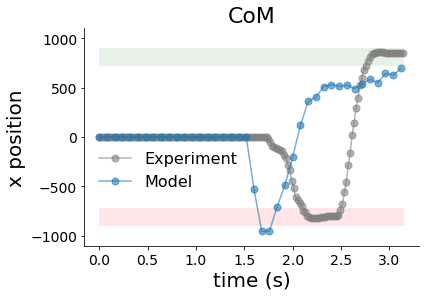

In [89]:
correct = True
com = True
coherence = 0.032
on_one_plot = True
specific_traj = (391, 1, 1, 20)

model_com_x_trajectory = pd.read_csv(os.path.join(csv_path, 'x_traj_com.txt'), sep=',')
plot_example_traj_x(model_com_x_trajectory, dynamics, choices, 'mouse', 
                    correct, com, coherence, on_one_plot, specific_traj=specific_traj)

Sample trajectory - non- CoM

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(391, 2, 4, 46)


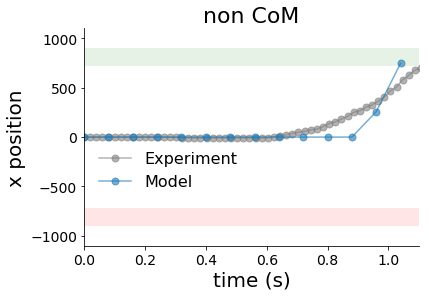

In [90]:
correct = True
com = False
coherence = 0.032
on_one_plot = True
specific_traj = (391, 2, 4, 46)
model_noncom_x_trajectory = pd.read_csv(os.path.join(csv_path, 'x_traj_non_com.txt'), sep=',')
plot_example_traj_x(model_noncom_x_trajectory, dynamics, choices, 'mouse', correct,
                    com, coherence, on_one_plot, specific_traj = specific_traj)

# To plot a random trajectory: 
# plot_example_traj_x(model_noncom_x_trajectory, dynamics_1, choices_1, 'mouse', correct,
#                     com, coherence, on_one_plot, specific_traj = None)

## x-y trajectories from the experiment

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


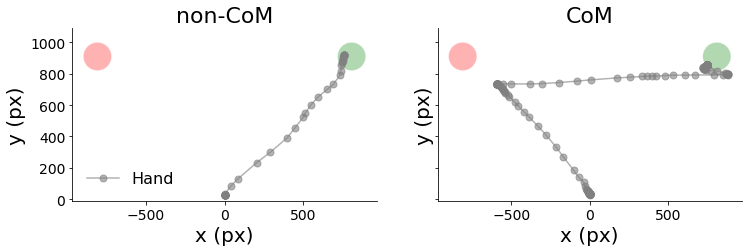

In [91]:
def plot_traj_xy(ax, trajectory, title):
    p = get_screen_params()
    ax.set_aspect('equal')
    ax.set_xlim(p['x_lim'])
    ax.set_ylim(p['y_lim'])
    left_resp_area = plt.Circle(p['left_resp_area_center'], p['resp_area_radius'], 
                                alpha=0.3, facecolor='red', edgecolor='white')
    right_resp_area = plt.Circle(p['right_resp_area_center'], p['resp_area_radius'], 
                                 alpha=0.3, facecolor='green', edgecolor='white')
    ax.add_artist(left_resp_area)
    ax.add_artist(right_resp_area)
    step=2
    ax.plot(trajectory.mouse_x[::step], trajectory.mouse_y[::step], marker='o', markersize=7, 
            alpha=0.6, label='Hand', color='grey')
    ax.set_title(title)
    ax.set_xlabel('x (px)')

def plot_example_traj_xy(dynamics, choices):
    
    global save_path
    local_save_path = save_path
    
    fig, (ax1, ax2) = plt.subplots(figsize=(12,4), nrows=1,ncols=2, sharex=True, sharey=True, squeeze=True)

    choices = choices.set_index(index)
    # non-CoM example
    dynamics_condition = dynamics[(choices.is_correct == True) & (choices.is_com == False) & (choices.coherence == 0.256)]
    index_values = dynamics_condition.index.values.tolist()
    trajectory = dynamics_condition.loc[index_values[np.random.randint(1,high=len(index_values)-1)]]

    plot_traj_xy(ax1, trajectory, 'non-CoM')

    ax1.set_ylabel('y (px)')
    ax1.legend(loc='lower left', frameon=False)
    
    # CoM example
    dynamics_condition = dynamics[(choices.is_correct == True) & (choices.is_com == True) & (choices.coherence == 0.256)]
    index_values = dynamics_condition.index.values.tolist()
    trajectory = dynamics_condition.loc[index_values[np.random.randint(1,high=len(index_values)-1)]]
    
    plot_traj_xy(ax2, trajectory, 'CoM')
    
    ax2.set_ylabel('y (px)')
    plt.savefig(os.path.join(local_save_path, 'traj_xy.png'), bbox_inches='tight')

plot_example_traj_xy(dynamics, choices)